# HyPro Preprocessing for CHTC

<hr>

In [1]:
import json
import logging

from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd

In [2]:
from enspec.config import GLOBUS_ENDPOINTS as endpoints
from enspec.database import EnSpecDB
from enspec.database.routines.pixel_size import pixel_size_estimation
from enspec.display.table import pretty_print
from enspec.filesystem.transfer import TransferOptions, HyProTransferSession
from enspec.processing.utilities.config import make_config
from enspec.processing.utilities.prepare_hyspex import generate_chtc_joblist, select_sessions, prepare_hyspex_inputs, prioritize_sessions

<hr>

In [3]:
db = EnSpecDB()

In [4]:
logger = logging.getLogger('enspec')
handler = logging.StreamHandler()
formatter = logging.Formatter(
    fmt='%(asctime)s ::: %(message)s',
    datefmt='%Y-%m-%dT%H:%M:%S'
)

logger.setLevel(logging.DEBUG)
handler.setFormatter(formatter)
logger.addHandler(handler)

<br>

# Processing

<hr>

## Select images to process

#### Examples

**1). Find Hancock images from 2023:**
```python
sessions, images = select_sessions(session='HARS', year=2023, comparison='startswith', return_images=True)
```


**2). Find WisAsp images from 2021 & 2022:**
```python
sessions, images = select_sessions(session=['GENO', 'COMP', 'ASPEN', 'Asp'], year=[2021, 2022], comparison='contains', return_images=True)
```


**3). Find LakeView images:**
```python
sessions, images = select_sessions(session=['LAKE', 'POND'], year=[2023, 2024], return_images=True)
```


**4). Find ash images from 2023:**
```python
# Just identify the session names manually
ash_session_names = [
    'ALLN', 'MKER', 'MKEF', 'THER', 'JACK', 'MUDL', 'JACK-2', 'GERM', 'WHIT', 'FOXR',
    'REDW', 'ROLL', 'FOXB', 'MENP', 'MENF', 'ABRD', 'MENO', 'LMEN', 'SHOR', 'LOEW',
    'HIAW', 'ALTN',  
]

sessions, images = select_sessions(session=ash_session_names, year=2023)
```


**5). Find images on a specific date:**
```python
flights = db.Flights.find_date('date', pd.Timestamp(datetime(year=2022, month=6, day=17)))
sessions, images = select_sessions(flights=flights, session='CCESR', comparison='contains', return_images=True)
```

In [5]:
sessions, images = select_sessions(session='BHKI', year=2024, return_images=True)
# sessions, images = select_sessions(session=['BHI', 'BHKI'], year=list(range(2019, 2025)), return_images=True)
sessions_ = sessions

### Check inputs

In [6]:
pretty_print(sessions.drop(columns=['notes_x', 'notes_y']))

,flight_id,date,aircraft,pilot,operator,battery,departing_airfield,landing_airfield,time_engine_on,time_liftoff,time_touchdown,time_engine_off,voltage_start,voltage_end,tachometer_start,tachometer_end,hobbs_start,hobbs_end,session_id,flightplan_id,session_name,target_altitude_ftAGL,target_altitude_ftMSL,target_groundspeed_kn,target_pixel_size_m,figure_eight,time_start,time_end,line_count
18,59ef9459-cabd-4ffe-9473-a2c873de4fbb,2024-05-03 00:00:00,Cessna N182NR,Mike Kakuska,Brendan Heberlein,SN105969,MSN - Madison,MSN - Madison,11:26:56,11:37:30,13:29:37,13:32:57,26.900000,0.000000,8866.100000,8868.000000,838.300000,840.400000,21561528-3a4e-47a6-8663-e9559369298b,nan,BHKI,1100.000000,2000.000000,95.000000,0.500000,True,12:04:33,12:27:04,12.000000
26,be2b1d0d-63ad-4cd3-909f-f60cad18e8b7,2024-05-10 00:00:00,Cessna N182NR,Mike Kakuska,Brendan Heberlein,SN105969,MSN - Madison,MSN - Madison,11:34:19,11:48:42,13:29:48,13:33:41,26.900000,26.000000,8869.500000,8871.300000,842.100000,844.000000,0c823066-ef95-44f5-a33f-d7248a8b9726,nan,BHKI,0.000000,2000.000000,100.000000,0.500000,True,12:17:01,12:39:03,12.000000
87,da12f1d0-409a-40e1-bc54-cb838ac1acc0,2024-07-26 00:00:00,Cessna N182NR,Mike Kakuska,Brendan Heberlein,SN105969,MSN - Madison,MSN - Madison,11:19:27,11:29:06,14:50:00,14:55:12,26.900000,25.800000,8919.800000,8923.000000,896.700000,900.200000,3bf229d8-a43f-4a0a-acd4-e829e2467dfc,nan,BHKI,0.000000,2000.000000,90.000000,0.500000,True,14:10:25,14:30:29,12.000000
97,dde00666-db8a-422b-995a-d1f17977276e,2024-08-19 00:00:00,Cessna N182NR,Mike Kakuska,Brendan Heberlein,SN105969,MSN - Madison,MSN - Madison,11:23:57,11:34:23,13:42:55,13:46:57,26.900000,26.000000,8927.400000,8929.800000,905.300000,907.700000,0e096824-df20-4afe-8c6f-c610d0044048,nan,BHKI,0.000000,2000.000000,100.000000,0.500000,True,12:43:06,13:23:09,nan
136,a96d29a3-fba3-4078-afdf-394e5dd61775,2024-09-25 00:00:00,Cessna N182NR,Mike Kakuska,Brendan Heberlein,SN105969,MSN - Madison,MSN - Madison,09:25:40,09:31:48,12:56:55,13:01:19,26.900000,25.700000,8950.100000,8953.500000,930.100000,933.700000,e2a8c7a1-88ab-4e91-af7f-05876670f155,nan,BHKI,0.000000,2000.000000,90.000000,0.500000,False,11:45:00,12:09:47,nan


In [7]:
pretty_print(images)

,session_id,session_name,line_id,line_number,image_id,filepath
0,21561528-3a4e-47a6-8663-e9559369298b,BHKI,d283425b-4da2-4268-b67e-1e6fba84d559,1,ddbf2ab6-3ba2-4c1d-8e40-74b93ad6daa0,Z:/data/collection/airborne/raw/2024/20240503/FLIGHT_20240503/FLIGHT_20240503_01_SWIR_384_SN3142_FOVx2_raw.hyspex
1,21561528-3a4e-47a6-8663-e9559369298b,BHKI,d283425b-4da2-4268-b67e-1e6fba84d559,1,471d6ba9-e341-4469-b53b-fa097b0208d8,Z:/data/collection/airborne/raw/2024/20240503/FLIGHT_20240503/FLIGHT_20240503_01_VNIR_1800_SN00840_FOVx2_raw.hyspex
2,21561528-3a4e-47a6-8663-e9559369298b,BHKI,f84bfaa4-5f79-44e8-8740-0e93b091294c,2,1eac2132-7795-4cd3-a69b-4ceffee20b36,Z:/data/collection/airborne/raw/2024/20240503/FLIGHT_20240503/FLIGHT_20240503_02_SWIR_384_SN3142_FOVx2_raw.hyspex
3,21561528-3a4e-47a6-8663-e9559369298b,BHKI,f84bfaa4-5f79-44e8-8740-0e93b091294c,2,5c3cc97a-ad90-46f2-b8fd-44b47452355a,Z:/data/collection/airborne/raw/2024/20240503/FLIGHT_20240503/FLIGHT_20240503_02_VNIR_1800_SN00840_FOVx2_raw.hyspex
4,21561528-3a4e-47a6-8663-e9559369298b,BHKI,31ab3b65-6855-4936-8acc-814ad63016f7,3,6f877303-f966-4d79-8c22-b05acc2d29fe,Z:/data/collection/airborne/raw/2024/20240503/FLIGHT_20240503/FLIGHT_20240503_03_SWIR_384_SN3142_FOVx2_raw.hyspex
5,21561528-3a4e-47a6-8663-e9559369298b,BHKI,31ab3b65-6855-4936-8acc-814ad63016f7,3,312a1980-a134-4de6-ba01-0c5af7950b94,Z:/data/collection/airborne/raw/2024/20240503/FLIGHT_20240503/FLIGHT_20240503_03_VNIR_1800_SN00840_FOVx2_raw.hyspex
6,21561528-3a4e-47a6-8663-e9559369298b,BHKI,290c1e6c-dd44-4781-a1e3-a70579d97ae8,4,7606c6d9-9803-4c24-ae05-177413f33a88,Z:/data/collection/airborne/raw/2024/20240503/FLIGHT_20240503/FLIGHT_20240503_04_SWIR_384_SN3142_FOVx2_raw.hyspex
7,21561528-3a4e-47a6-8663-e9559369298b,BHKI,290c1e6c-dd44-4781-a1e3-a70579d97ae8,4,9a3fb7bc-121a-43d9-b7c4-0759c342d357,Z:/data/collection/airborne/raw/2024/20240503/FLIGHT_20240503/FLIGHT_20240503_04_VNIR_1800_SN00840_FOVx2_raw.hyspex
8,21561528-3a4e-47a6-8663-e9559369298b,BHKI,ad48f524-ee34-47d7-a249-892ae6721b33,5,6e6ec2b6-fe46-4417-92bb-1a8c518f474c,Z:/data/collection/airborne/raw/2024/20240503/FLIGHT_20240503/FLIGHT_20240503_05_SWIR_384_SN3142_FOVx2_raw.hyspex
9,21561528-3a4e-47a6-8663-e9559369298b,BHKI,ad48f524-ee34-47d7-a249-892ae6721b33,5,96be762f-c872-4d81-989d-424f0c82949e,Z:/data/collection/airborne/raw/2024/20240503/FLIGHT_20240503/FLIGHT_20240503_05_VNIR_1800_SN00840_FOVx2_raw.hyspex


In [8]:
print(f'{len(images.session_id.unique())} sessions found.')
print(f'{len(images.line_id.unique())} flightlines found.')

5 sessions found.
70 flightlines found.


In [9]:
sessions.target_pixel_size_m

18     0.5
26     0.5
87     0.5
97     0.5
136    0.5
Name: target_pixel_size_m, dtype: float64

### Set session priority


#### Examples

**Prioritize certain sessions for processing:**
```python
# Order image queue by site priority (put WHIT first)
sessions_ = prioritize_sessions(sessions, sessions.session_name.str.startswith('WHIT'))
```

In [10]:
sessions_ = sessions

<br>

## Check pixel sizes

<hr>

In [30]:
swir_images = images[images.filepath.apply(lambda f: 'SWIR_384_SN3142' in f)]

In [31]:
est_pixel_sizes = swir_images.filepath.apply(pixel_size_estimation)

<Axes: >

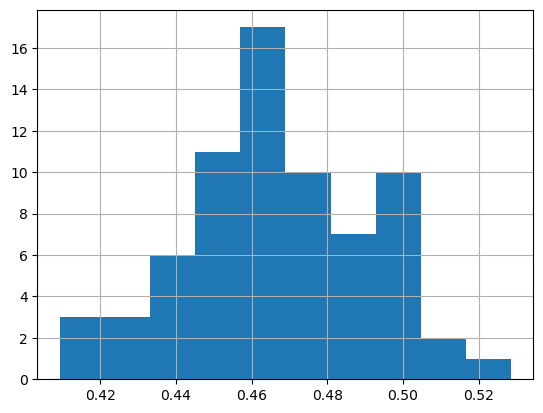

In [33]:
est_pixel_sizes.hist()  #(bins=50)

<br>

## Set up variables & paths

<hr>

In [71]:
PROJECT, SITE, YEAR = 'BHKI', 'BHKI', 2024

VDATUM = 'geoid'
# VDATUM = 'ellipsoid'

In [72]:
enspec = Path('Z:/')
hyspex = enspec/'data/collection/airborne/raw'

In [73]:
# Top-level processing directory
PROCESSING = enspec/f'users/jcwilson22/processing/{YEAR}'
# Packaged job inputs will go here
STAGING = PROCESSING/PROJECT/'raw-inputs'
STAGING.mkdir(exist_ok=True, parents=True)

<br>

## Package raw inputs

<hr>

In [74]:
# options = TransferOptions()
# options = TransferOptions(force=True)

PACKAGING_START = datetime.now()

# Package up raw inputs for each flightline
prepare_hyspex_inputs(sessions_, STAGING, vdatum=VDATUM, compress=True)#, transfer=options)

PACKAGING_FINISH = datetime.now()

DURATION = (PACKAGING_FINISH - PACKAGING_START).total_seconds()

n_flightlines = len(images)//2
total_minutes = DURATION//60

print(f'Packaged raw inputs for {n_flightlines} flightlines in {total_minutes:.1f} minutes ({total_minutes/n_flightlines:.1f} min/line).')

2024-11-18T09:35:27 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240503 01
2024-11-18T09:35:27 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240503 01
2024-11-18T09:35:27 ::: "FLIGHT_20240503_01_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240503_01_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T09:35:27 ::: "FLIGHT_20240503_01_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240503_01_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T09:37:04 ::: "FLIGHT_20240503_01_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240503_01_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T09:37:04 ::: "FLIGHT_20240503_01_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240503_01_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T09:37:04 ::: "FLIGHT_20240503_01_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240503_01_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T09:37:04 ::: "FLIGHT_20240503_01_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240503_01_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T09:37:04 ::: "FLIGHT_20240503_01_VNIR_1800_SN00840_FOVx

2024-11-18T10:33:37 ::: "FLIGHT_20240503_05_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240503_05_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T10:46:46 ::: "FLIGHT_20240503_05_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240503_05_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T10:46:46 ::: "FLIGHT_20240503_05_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240503_05_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T10:46:46 ::: "FLIGHT_20240503_05_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240503_05_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T10:46:46 ::: "FLIGHT_20240503_05_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240503_05_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T10:46:47 ::: Done.
2024-11-18T10:46:47 ::: Done.
2024-11-18T10:46:47 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240503 06
2024-11-18T10:46:47 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240503 06
2024-11-18T10:46:47 ::: "FLIGHT_20240503_06_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240503_06_SWIR_384_SN3142_FOVx

2024-11-18T11:39:16 ::: "FLIGHT_20240503_10_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240503_10_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T11:39:16 ::: "FLIGHT_20240503_10_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240503_10_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T11:39:16 ::: "FLIGHT_20240503_10_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240503_10_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T11:39:16 ::: "FLIGHT_20240503_10_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240503_10_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T11:39:16 ::: "FLIGHT_20240503_10_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240503_10_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T11:39:16 ::: "FLIGHT_20240503_10_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240503_10_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T11:46:20 ::: "FLIGHT_20240503_10_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240503_10_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T11:46:20 ::: "FLIGHT_20240503_10_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240503_

2024-11-18T12:26:05 ::: "FLIGHT_20240510_03_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240510_02_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T12:26:06 ::: Done.
2024-11-18T12:26:06 ::: Done.
2024-11-18T12:26:06 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240510 03
2024-11-18T12:26:06 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240510 03
2024-11-18T12:26:06 ::: "FLIGHT_20240510_04_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240510_03_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T12:26:06 ::: "FLIGHT_20240510_04_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240510_03_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T12:27:51 ::: "FLIGHT_20240510_04_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240510_03_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T12:27:51 ::: "FLIGHT_20240510_04_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240510_03_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T12:27:51 ::: "FLIGHT_20240510_04_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240510_03_SWIR_384_SN3142_FOVx2_raw.txt"
20

2024-11-18T13:22:28 ::: "FLIGHT_20240510_08_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240510_07_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T13:22:28 ::: "FLIGHT_20240510_08_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240510_07_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T13:33:23 ::: "FLIGHT_20240510_08_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240510_07_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T13:33:23 ::: "FLIGHT_20240510_08_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240510_07_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T13:33:23 ::: "FLIGHT_20240510_08_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240510_07_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T13:33:23 ::: "FLIGHT_20240510_08_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240510_07_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T13:33:24 ::: Done.
2024-11-18T13:33:24 ::: Done.
2024-11-18T13:33:24 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240510 08
2024-11-18T13:33:24 ::: Preparing .TAR.GZ archive for flightline:

2024-11-18T14:14:10 ::: "FLIGHT_20240510_13_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240510_12_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T14:15:46 ::: "FLIGHT_20240510_13_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240510_12_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T14:15:46 ::: "FLIGHT_20240510_13_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240510_12_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T14:15:46 ::: "FLIGHT_20240510_13_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240510_12_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T14:15:46 ::: "FLIGHT_20240510_13_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240510_12_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T14:15:46 ::: "FLIGHT_20240510_13_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240510_12_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T14:15:46 ::: "FLIGHT_20240510_13_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240510_12_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T14:25:26 ::: "FLIGHT_20240510_13_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_2024051

2024-11-18T15:07:27 ::: "FLIGHT-2_20240726_10_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240726_04_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T15:07:27 ::: "FLIGHT-2_20240726_10_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240726_04_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T15:07:27 ::: "FLIGHT-2_20240726_10_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240726_04_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T15:07:27 ::: Done.
2024-11-18T15:07:27 ::: Done.
2024-11-18T15:07:27 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240726 05
2024-11-18T15:07:27 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240726 05
2024-11-18T15:07:27 ::: "FLIGHT-2_20240726_11_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240726_05_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T15:07:27 ::: "FLIGHT-2_20240726_11_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240726_05_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T15:09:17 ::: "FLIGHT-2_20240726_11_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240726_05_SWIR_384_SN31

2024-11-18T16:00:42 ::: "FLIGHT-2_20240726_15_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240726_09_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T16:00:42 ::: "FLIGHT-2_20240726_15_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240726_09_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T16:00:42 ::: "FLIGHT-2_20240726_15_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240726_09_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T16:00:42 ::: "FLIGHT-2_20240726_15_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240726_09_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T16:00:42 ::: "FLIGHT-2_20240726_15_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240726_09_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T16:09:35 ::: "FLIGHT-2_20240726_15_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240726_09_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T16:09:35 ::: "FLIGHT-2_20240726_15_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240726_09_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T16:09:35 ::: "FLIGHT-2_20240726_15_VNIR_1800_SN00840_FOVx2_raw.tx

2024-11-18T16:49:00 ::: "FLIGHT_20240819_09_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240819_01_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T16:49:00 ::: Done.
2024-11-18T16:49:00 ::: Done.
2024-11-18T16:49:01 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240819 02
2024-11-18T16:49:01 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240819 02
2024-11-18T16:49:01 ::: "FLIGHT_20240819_10_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240819_02_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T16:49:01 ::: "FLIGHT_20240819_10_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240819_02_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T16:50:30 ::: "FLIGHT_20240819_10_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240819_02_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T16:50:30 ::: "FLIGHT_20240819_10_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240819_02_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T16:50:30 ::: "FLIGHT_20240819_10_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240819_02_SWIR_384_SN3142_FOVx2_raw.txt"
20

2024-11-18T17:34:17 ::: "FLIGHT_20240819_14_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240819_06_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T17:34:17 ::: "FLIGHT_20240819_14_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240819_06_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T17:39:02 ::: "FLIGHT_20240819_14_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240819_06_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T17:39:02 ::: "FLIGHT_20240819_14_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240819_06_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T17:39:02 ::: "FLIGHT_20240819_14_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240819_06_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T17:39:02 ::: "FLIGHT_20240819_14_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240819_06_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T17:39:02 ::: Done.
2024-11-18T17:39:02 ::: Done.
2024-11-18T17:39:03 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240819 07
2024-11-18T17:39:03 ::: Preparing .TAR.GZ archive for flightline:

2024-11-18T18:09:56 ::: "FLIGHT_20240819_19_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240819_11_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T18:11:17 ::: "FLIGHT_20240819_19_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240819_11_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T18:11:17 ::: "FLIGHT_20240819_19_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240819_11_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T18:11:17 ::: "FLIGHT_20240819_19_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240819_11_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T18:11:17 ::: "FLIGHT_20240819_19_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240819_11_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T18:11:18 ::: "FLIGHT_20240819_19_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240819_11_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T18:11:18 ::: "FLIGHT_20240819_19_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240819_11_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T18:19:28 ::: "FLIGHT_20240819_19_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_2024081

2024-11-18T19:04:18 ::: "FLIGHT_20240819_23_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240819_15_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T19:04:18 ::: "FLIGHT_20240819_23_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240819_15_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T19:04:18 ::: Done.
2024-11-18T19:04:18 ::: Done.
2024-11-18T19:04:18 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240819 16
2024-11-18T19:04:18 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240819 16
2024-11-18T19:04:18 ::: "FLIGHT_20240819_24_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240819_16_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T19:04:18 ::: "FLIGHT_20240819_24_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240819_16_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T19:05:47 ::: "FLIGHT_20240819_24_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240819_16_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T19:05:47 ::: "FLIGHT_20240819_24_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240819_16_SWIR_384_SN3142_FOVx2_raw.hdr

2024-11-18T19:49:27 ::: "FLIGHT_20240925_25_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240925_01_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T19:49:27 ::: "FLIGHT_20240925_25_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240925_01_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T19:49:27 ::: "FLIGHT_20240925_25_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240925_01_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T19:56:18 ::: "FLIGHT_20240925_25_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240925_01_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T19:56:18 ::: "FLIGHT_20240925_25_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240925_01_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T19:56:18 ::: "FLIGHT_20240925_25_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240925_01_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T19:56:18 ::: "FLIGHT_20240925_25_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240925_01_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T19:56:19 ::: Done.
2024-11-18T19:56:19 ::: Done.
2024-11-18T19:56:19 ::

2024-11-18T20:46:18 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240925 06
2024-11-18T20:46:18 ::: "FLIGHT_20240925_30_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240925_06_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T20:46:18 ::: "FLIGHT_20240925_30_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240925_06_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T20:48:13 ::: "FLIGHT_20240925_30_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240925_06_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T20:48:13 ::: "FLIGHT_20240925_30_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240925_06_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T20:48:13 ::: "FLIGHT_20240925_30_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240925_06_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T20:48:13 ::: "FLIGHT_20240925_30_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240925_06_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T20:48:13 ::: "FLIGHT_20240925_30_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240925_06_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T20

2024-11-18T21:33:21 ::: "FLIGHT_20240925_34_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240925_10_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T21:33:21 ::: "FLIGHT_20240925_34_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240925_10_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T21:33:21 ::: "FLIGHT_20240925_34_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240925_10_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T21:33:21 ::: "FLIGHT_20240925_34_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240925_10_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T21:33:21 ::: Done.
2024-11-18T21:33:21 ::: Done.
2024-11-18T21:33:21 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240925 11
2024-11-18T21:33:21 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240925 11
2024-11-18T21:33:21 ::: "FLIGHT_20240925_35_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240925_11_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T21:33:21 ::: "FLIGHT_20240925_35_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240925_11_SWIR_384_SN3142_FOVx2_ra

2024-11-18T22:16:01 ::: "FLIGHT_20240925_39_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240925_15_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T22:16:01 ::: "FLIGHT_20240925_39_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240925_15_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T22:16:01 ::: "FLIGHT_20240925_39_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240925_15_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T22:16:01 ::: "FLIGHT_20240925_39_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240925_15_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T22:16:01 ::: "FLIGHT_20240925_39_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240925_15_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T22:25:17 ::: "FLIGHT_20240925_39_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240925_15_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T22:25:17 ::: "FLIGHT_20240925_39_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240925_15_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T22:25:17 ::: "FLIGHT_20240925_39_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240

Packaged raw inputs for 70 flightlines in 769.0 minutes (11.0 min/line).


<br>

# Copy Files to CHTC Staging with Globus

#### Examples

**Transfer all subdirectories within an input directory:**
```python
# Transfer files to CHTC Staging via Globus
*transfers, = session.transfer_subdirectories(STAGING)
```

**Filter out subdirectories by name:**
```python
# Only include directories with names beginning with "HARS"
*transfers, = session.transfer_subdirectories(STAGING, criterion=lambda dirname: dirname.startswith('HARS'))
```

**Transfer just a single directory:**
```python
basename = 'WHIT_20240515'
transfer = session.submit_transfer(sorted((STAGING/basename).iterdir()), basename)
```


In [75]:
# Select source & target endpoints
source = '13a5c533-b31d-421f-96f3-0551090a029f'
# source = endpoints.ENSPEC_FARNSWORTH
target = endpoints.CHTC_STAGING

# Set destination path on CHTC Staging
destination_path = Path('/groups/townsend_hyspex/data/raw')

session = HyProTransferSession(source, target, path=destination_path)

In [76]:
STAGING

WindowsPath('Z:/users/jcwilson22/processing/2024/BHKI/raw-inputs')

In [78]:
def relevant_subdir(dirname):
    return True
#     return Path(dirname).name.startswith('HARS_2024')

In [79]:
# Transfer files to CHTC Staging via Globus
*transfers, = session.transfer_subdirectories(STAGING, criterion=relevant_subdir)

2024-11-19T08:19:07 ::: New Transfer: "Transfer HyPro Inputs - BHKI_20240503"
2024-11-19T08:19:07 ::: New Transfer: "Transfer HyPro Inputs - BHKI_20240503"
2024-11-19T08:19:08 ::: Collecting files for transfer...
2024-11-19T08:19:08 ::: Collecting files for transfer...
2024-11-19T08:19:08 :::  > BHKI_20240503_01.tar.gz
2024-11-19T08:19:08 :::  > BHKI_20240503_01.tar.gz
2024-11-19T08:19:08 :::  > BHKI_20240503_02.tar.gz
2024-11-19T08:19:08 :::  > BHKI_20240503_02.tar.gz
2024-11-19T08:19:08 :::  > BHKI_20240503_03.tar.gz
2024-11-19T08:19:08 :::  > BHKI_20240503_03.tar.gz
2024-11-19T08:19:08 :::  > BHKI_20240503_04.tar.gz
2024-11-19T08:19:08 :::  > BHKI_20240503_04.tar.gz
2024-11-19T08:19:08 :::  > BHKI_20240503_05.tar.gz
2024-11-19T08:19:08 :::  > BHKI_20240503_05.tar.gz
2024-11-19T08:19:08 :::  > BHKI_20240503_06.tar.gz
2024-11-19T08:19:08 :::  > BHKI_20240503_06.tar.gz
2024-11-19T08:19:08 :::  > BHKI_20240503_07.tar.gz
2024-11-19T08:19:08 :::  > BHKI_20240503_07.tar.gz
2024-11-19T08:19

2024-11-19T08:19:15 :::  > BHKI_20240925_03.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_04.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_04.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_05.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_05.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_06.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_06.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_07.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_07.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_08.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_08.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_09.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_09.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_10.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_10.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_11.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_11.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_12.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_12.tar.gz
2024-11-19T08:19:15 :::  > BHKI

<br>

# Generate `JobList.txt`

<hr>

In [80]:
# Whether input archives are compressed or not
USE_COMPRESSION = True

# Approximate compression ratio, estimated by comparing .TAR vs .TAR.GZ files
COMPRESSION_RATIO = 0.6 # 0.84

In [83]:
# Generate job list files
generate_chtc_joblist(STAGING, SITE, project=f'{PROJECT}_{YEAR}', filter_by=relevant_subdir,
                      use_compression=USE_COMPRESSION, compression_ratio=COMPRESSION_RATIO)

In [84]:
STAGING

WindowsPath('Z:/users/jcwilson22/processing/2024/BHKI/raw-inputs')

<br>

# Generate Config File

<hr>

In [81]:
config_file = STAGING/f'{PROJECT}_{YEAR}_Config.json'

dem_file = '/staging/groups/townsend_hyspex/data/surface/Blackhawk_DEM_DSM/bhi_dem_utm16_wgs84_meters_1m_egm'

In [82]:
make_config(config_file, vnir_pixel_size=0.5/2, dem_file=dem_file)